In [117]:
class CFG:
    input_path = '../input/us-patent-phrase-to-phrase-matching/'
    #model_path = ["../input/uspppm-debertv3large-5folds/","../input/uspppm-bert-for-patents-baseline-5folds/",
    #             "../input/uspppm-debertv3large-5folds-v2/","../input/berttrain/","../input/uspppmdebertav3/",
    #              "../input/uspppm-bert-train-v3/","../input/uspppm-deberta-v3/"]
    #model_path = ["../input/uspppm-debertv3large-5folds/uspppm_1", "../input/berttrain/uspppm_3","../input/berttrain/uspppm_4"]
    #model_path = ["../input/uspppm-bert-for-patents-baseline-5folds/","../input/berttrain/","../input/uspppmdebertav3/"]
    #model_path = ["../input/uspppm-bert-train-v3/"]
    #model_path = ["../input/uspppm-deberta-v3/"]
    model_path = ["../input/uspppm-bert-train-v3/","../input/uspppm-deberta-v3/"]
    
    learning_rate = 2e-5
    weight_decay = 0.01
    num_fold = 5
    epochs = 5
    batch_size = 32
    self_testing = False

In [118]:
def preproc(modelname, self_testing):
    sections = {"A" : "Human Necessities", 
                "B" : "Operations and Transport",
                "C" : "Chemistry and Metallurgy",
                "D" : "Textiles",
                "E" : "Fixed Constructions",
                "F" : "Mechanical Engineering",
                "G" : "Physics",
                "H" : "Electricity",
                "Y" : "Emerging Cross-Sectional Technologies"}

    titles = pd.read_csv('../input/cpc-codes/titles.csv')
    if not self_testing:
        test_df = pd.read_csv(f"{CFG.input_path}test.csv")
        test_df = test_df.merge(titles, left_on='context', right_on='code')
        test_df['input'] = test_df['section'] + " "+ test_df['class'].astype(str) + " " +test_df['title']+' [SEP] '+test_df['anchor']

    else:
        train_df = pd.read_csv(f"{CFG.input_path}train.csv")
        train_df = train_df.merge(titles, left_on = "context", right_on = 'code')
        train_df["input"] = train_df['section'] + " "+ train_df['class'].astype(str) + " " +train_df['title']+' [SEP] '+train_df['anchor']
        val_df = train_df.sample(128, random_state = 1996)
        test_df = val_df

    if modelname == "../input/uspppm-bert-train-v3/":
        test_df['topic'] = test_df['section'].map(sections).str.lower()
        test_df['input'] = test_df['section'] + " " + test_df['class'].astype(str) + " " + test_df['topic'] + ' ' +\
                            test_df['title'].str.lower() + " - " + test_df['anchor']
        
    return test_df

In [122]:
test_df = preproc('modelname', True)
test_df

,id,anchor,target,context,score,code,title,section,class,subclass,group,main_group,input
4255,966366e95e05ffc1,el display,el panel,H01,0.75,H01,BASIC ELECTRIC ELEMENTS,H,1.0,NaN,NaN,NaN,H 1.0 BASIC ELECTRIC ELEMENTS [SEP] el display
19145,24c0c8b0bade53a4,component control,neural control interface,B60,0.00,B60,VEHICLES IN GENERAL,B,60.0,NaN,NaN,NaN,B 60.0 VEHICLES IN GENERAL [SEP] component con...
9445,8488ce1613071ce2,arcuate means,arcuate nucleus,D03,0.00,D03,WEAVING,D,3.0,NaN,NaN,NaN,D 3.0 WEAVING [SEP] arcuate means
31192,40ee3622c6a9f43e,embossing portion,food portion,B44,0.00,B44,DECORATIVE ARTS,B,44.0,NaN,NaN,NaN,B 44.0 DECORATIVE ARTS [SEP] embossing portion
7753,b94724a59eea10d6,service processing unit,service control unit,H04,0.75,H04,ELECTRIC COMMUNICATION TECHNIQUE,H,4.0,NaN,NaN,NaN,H 4.0 ELECTRIC COMMUNICATION TECHNIQUE [SEP] s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,c87442c7c75f7af3,exhibit symmetry,conductive element pattern,H01,0.25,H01,BASIC ELECTRIC ELEMENTS,H,1.0,NaN,NaN,NaN,H 1.0 BASIC ELECTRIC ELEMENTS [SEP] exhibit sy...
2855,a4f13cb83d2a1d81,lower trunnion,rocker arm,F16,0.25,F16,ENGINEERING ELEMENTS AND UNITS; GENERAL MEASUR...,F,16.0,NaN,NaN,NaN,F 16.0 ENGINEERING ELEMENTS AND UNITS; GENERAL...
1356,e7250e836b4f7612,modify before use,associated change,A61,0.25,A61,MEDICAL OR VETERINARY SCIENCE; HYGIENE,A,61.0,NaN,NaN,NaN,A 61.0 MEDICAL OR VETERINARY SCIENCE; HYGIENE ...
21896,a42d6f5004023268,fan,brake noises,B61,0.25,B61,RAILWAYS,B,61.0,NaN,NaN,NaN,B 61.0 RAILWAYS [SEP] fan


In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = list(predictions), list(labels)
    
    return np.corrcoef(predictions, labels)[0][1]

def BackTrac(models, model, m, n):
    # models : list of combinations of model, [model0, model1, ...]
    # model : current model
    # m : number of models
    if len(model) > n:
        return
    if model and not model in models and len(model)==n:
        models.add(model)
    
    for i in range(m):
        if not i in model: BackTrac(models, model.union(frozenset([i])), m, n)

In [25]:
import pandas as pd
import numpy as np

predictions = pd.read_csv('../input/prediction2/predictions_1.csv', index_col=None, squeeze=True)
predictions.reset_index(drop = True)

labels = predictions['label']

res = []

#construct models
models = set()
m, n = len(predictions.columns) - 1, 3
BackTrac(models, frozenset([]), m, n)
models = [list(mo) for mo in models]
models.sort(key = lambda x: (len(x), x[0]))

#calculate pearson correlation
for mo in models:
    prediction = [predictions[str(m)] for m in mo] 
    prediction = np.mean(prediction, axis=0)
    eval_pred = prediction, labels
    
    res.append([mo,compute_metrics(eval_pred)])
    
res.sort(key = lambda x: x[1], reverse = True)

In [26]:
#firt n models
n = 15
res[:n]

[[[1, 13, 17], 0.9823584665945546],
 [[1, 19, 17], 0.982157202102143],
 [[1, 20, 17], 0.9817149697455904],
 [[1, 27, 17], 0.9816360719021291],
 [[1, 29, 17], 0.9814764458288571],
 [[16, 1, 17], 0.9814759187066556],
 [[27, 1, 19], 0.9807766950935509],
 [[1, 28, 17], 0.9804961047726155],
 [[1, 27, 13], 0.9804298419005704],
 [[1, 27, 20], 0.9801700526285286],
 [[1, 17, 22], 0.9801622820569127],
 [[1, 19, 13], 0.9801504267447749],
 [[1, 18, 17], 0.9800470704120641],
 [[16, 1, 27], 0.9796439222827014],
 [[1, 27, 29], 0.9795286204391574]]

In [27]:
import collections

goodmodels = collections.defaultdict(int)

for re in res[:n]:
    for r in re[0]:
        goodmodels[r]+=1
        
goodmodels = list(goodmodels.items())

goodmodels.sort(key = lambda x: x[1], reverse = True)
goodmodels

[(1, 15),
 (17, 9),
 (27, 6),
 (13, 3),
 (19, 3),
 (20, 2),
 (29, 2),
 (16, 2),
 (28, 1),
 (22, 1),
 (18, 1)]

In [31]:
m, n = len(predictions.columns) - 1, 3
predictions1 = [predictions[str(p)] for p in range(m)]
predictions1[0][0]

0.76937646

# Error Analysis

True count: Counter({0.25: 41, 0.5: 35, 0.0: 33, 0.75: 13, 1.0: 6})


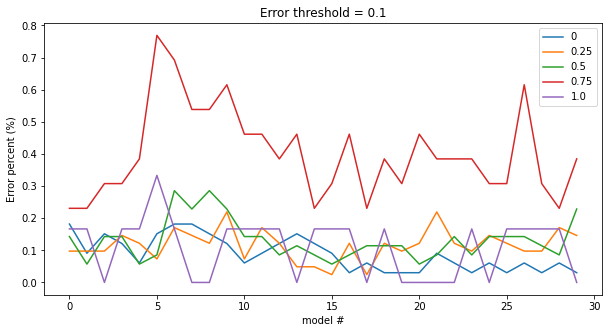

In [55]:
from matplotlib import pyplot as plt
#count for each category in true data
TrueCount = collections.Counter(labels)
print('True count:', TrueCount)
#error count for each category in pred data
PredCount = []

#threshold for misclassification
error = 0.1

for i,prediction in enumerate(predictions1):
    temp = {0.0:0,0.25:0,0.5:0, 0.75:0, 1.0:0}
    for p, l in zip(prediction, labels):
        if abs(p-l)>error:
            temp[l] += 1
    PredCount.append(temp)

# merge into each category for all models
keys = [0, 0.25, 0.5, 0.75, 1.0]
models = collections.defaultdict(list)
for p in PredCount:
    for k in keys:
        p[k] /= TrueCount[k]
        models[k].append(p[k])

#plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

for k in keys:
    plt.plot(models[k], label=k)
    
ax.set_title('Error threshold = %s'%error)
ax.set_xlabel('model #')
ax.set_ylabel('Error percent (%)')
ax.legend(loc='best')
plt.show()

: 0.75 category has largest error 

* So what has been predicted for 0.75 ?

Case index for 0.75: [0, 4, 9, 12, 14, 18, 32, 37, 60, 69, 89, 106, 116]


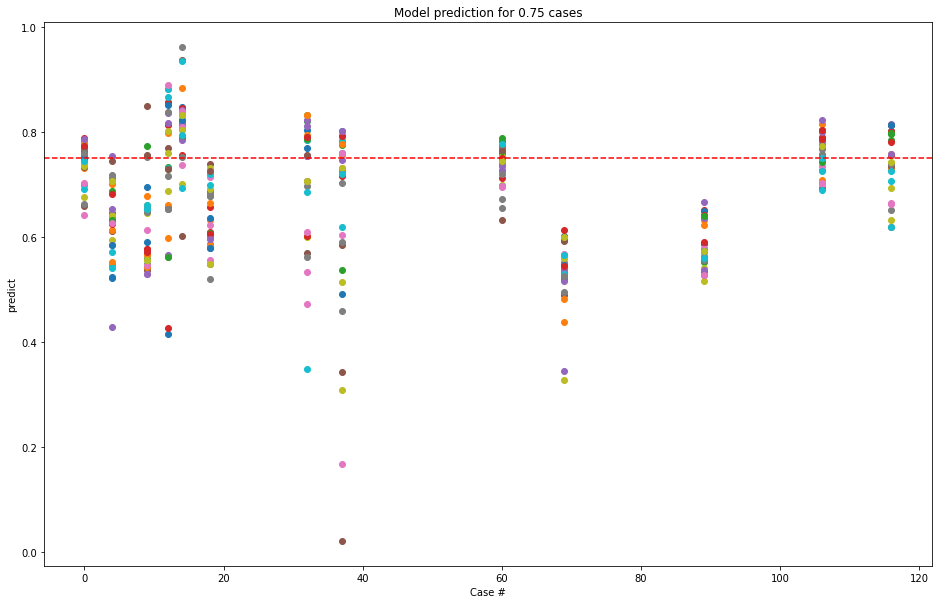

In [130]:
index = [i for i,l in enumerate(labels) if l==0.75]

print("Case index for 0.75:", index)

fig = plt.figure(figsize=(35,10))
ax = fig.add_subplot(121)
for i in range(m):
    plt.scatter(index,predictions1[i][index], label = 'model%s'%i)
    

#ax.set_title('Error threshold = %s'%error)
plt.axhline(y=0.75, color='r', linestyle='--')
ax.set_xlabel('Case #')
ax.set_ylabel('predict')
ax.set_title('Model prediction for 0.75 cases')
#ax.legend(loc='best')
plt.show()

Case index for 0.75: [0, 4, 9, 12, 14, 18, 32, 37, 60, 69, 89, 106, 116]


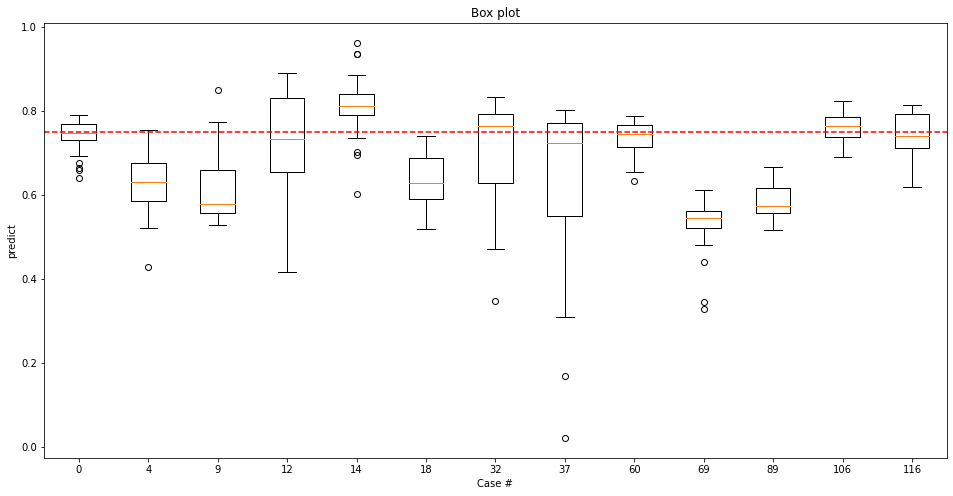

In [131]:
#pyplot.boxplot
fig = plt.figure(figsize=(55,8))
ax = fig.add_subplot(131)
print("Case index for 0.75:", index)
p = []
for ind in index:
    p.append([predictions1[i][ind] for i in range(m)])
    
ax.boxplot(p, labels = index)
plt.axhline(y=0.75, color='r', linestyle='--')
ax.set_xlabel('Case #')
ax.set_ylabel('predict')
ax.set_title('Box plot')
plt.show()

1. Most of the model under estimate the value
2. All low estimate at case 69, 89

What are the input?

In [132]:
test_df.iloc[[69,89],[1,2,4,12]]

,anchor,target,score,input
6752,ingress buffer,packet metadata queue,0.75,H 4.0 ELECTRIC COMMUNICATION TECHNIQUE [SEP] i...
32091,well pump,deep well pump,0.75,"F 3.0 MACHINES OR ENGINES FOR LIQUIDS; WIND, S..."


In [133]:
test_df.iloc[index,[1,2,4,12]]

,anchor,target,score,input
4255,el display,el panel,0.75,H 1.0 BASIC ELECTRIC ELEMENTS [SEP] el display
7753,service processing unit,service control unit,0.75,H 4.0 ELECTRIC COMMUNICATION TECHNIQUE [SEP] s...
35634,end pins,screw end pins,0.75,G 10.0 MUSICAL INSTRUMENTS; ACOUSTICS [SEP] en...
33771,hexahydro,hexahydride,0.75,C 13.0 SUGAR INDUSTRY [SEP] hexahydro
15215,summits,apexes,0.75,B 65.0 CONVEYING; PACKING; STORING; HANDLING T...
32928,flexible belt,flexible element,0.75,"E 1.0 CONSTRUCTION OF ROADS, RAILWAYS, OR BRID..."
16128,fdi,field device integration,0.75,G 1.0 MEASURING; TESTING [SEP] fdi
3722,pneumatic logic,pneumatic theory,0.75,F 28.0 HEAT EXCHANGE IN GENERAL [SEP] pneumati...
18389,agitate means,mixing means,0.75,"B 28.0 WORKING CEMENT, CLAY, OR STONE [SEP] ag..."
6752,ingress buffer,packet metadata queue,0.75,H 4.0 ELECTRIC COMMUNICATION TECHNIQUE [SEP] i...
